In [1]:
#https://github.com/abhinavsagar/plant-disease/blob/master/code/part2.ipynb

In [2]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
epochs = 2
batch_size = 150
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 6
seed = random.randint(1, 1000)

data_dir = "/content/drive/MyDrive/thesis_dataset_all/training_set"
data_dir1 = "/content/drive/MyDrive/thesis_dataset_all/test_set"

In [4]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 476 images belonging to 6 classes.
Found 39 images belonging to 6 classes.


/content/drive/MyDrive/thesis_dataset_all/training_set/Leprosy in cat/1 (50).jpg


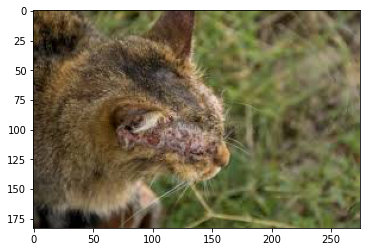

In [6]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [10]:
checkpoint = ModelCheckpoint('CatDogDiseaseswithMobilenet.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [11]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [12]:
%%time

history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Learning rate:  1e-04
Epoch 1/2
4/4 [==============================] - ETA: 0s - loss: 1.8016 - accuracy: 0.3487
Epoch 1: val_accuracy improved from -inf to 0.23077, saving model to CatDogDiseaseswithMobilenet.h5
4/4 [==============================] - 22s 4s/step - loss: 1.8016 - accuracy: 0.3487 - val_loss: 1.6790 - val_accuracy: 0.2308 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 2/2
4/4 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.7899
Epoch 2: val_accuracy improved from 0.23077 to 0.38462, saving model to CatDogDiseaseswithMobilenet.h5
4/4 [==============================] - 16s 4s/step - loss: 0.6701 - accuracy: 0.7899 - val_loss: 1.4957 - val_accuracy: 0.3846 - lr: 1.0000e-04
CPU times: user 42.7 s, sys: 1.18 s, total: 43.9 s
Wall time: 45.9 s
